In [1]:
from syntax_sugar import END, pipe
from syntax_sugar import process_syntax as p
from syntax_sugar import thread_syntax as t
NTHR = 16
import os
from os.path import join

In [2]:
from scipy.integrate import quad

import TMQGP as tm
from numpy import *

import QuarkTM
from QuarkTM import Channel, ChannelGroup, ChannelL, Particle

import matplotlib
matplotlib.style.use('publication23')

mQ = 0.6


qrange = linspace(0, 5, 51)
erange = linspace(-5, 5, 201)
eps = 5e-2
# pt = QuarkTM.Particle(mQ, qrange, erange, eps=5e-2)

G = 6
L = 0.5
screen = 0
G1 = 5


# ch = QuarkTM.Channel(pt, pt, T, G=8, screen=0, ds=4, da=1, Fa=1)

import tqdm

from scipy.optimize import minimize

params = {'G' : G, 'L' : L, 'screen' : screen}
params1 = {'G' : G1, 'L' : L, 'screen' : screen}
pss = [params, params1]
mu = 0
lmax = 1

# General setup 

In [3]:
T_init = 0.16
T = 0.2

In [4]:
# init_dir = 'QP_output/first_run/%.2f'%T_init
init_dir = None

In [5]:
if init_dir == None:
    ImS_Ks = [[-5e-2 for q in qrange]]*2
    ImS_K_Arr = array([[-5e-2 for e in erange] for q in qrange]).transpose()
    ImS_K_Arrs = [ImS_K_Arr, ImS_K_Arr]
    ReS = array([[0. for e in erange] for q in qrange]).transpose()
    omk = sqrt(mQ**2 + qrange**2)
    omKs = [omk, omk]
    # omArr = array([sqrt(mQ**2 + qrange**2) for e in erange])
    # omArrs = [omArr, omArr]
else:
    ImS_Ks = np.loadtxt(join(init_dir, 'ImS_Ks.dat'))
    omKs = np.loadtxt(join(init_dir, 'om_Ks.dat'))
eArr = array([erange for q in qrange]).transpose()


delta = 1

In [26]:
out_dir = 'QP_output/first_run/%.2f'%T

In [27]:
out_dir

'QP_output/first_run/0.20'

In [28]:
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

## Getting the T-matrix

Continue with the iterations

In [8]:
mu = 0.*T
delta = 1

In [9]:
import warnings

warnings.filterwarnings('ignore')

In [34]:
omK_iters = []
S_iters = []
G_iters = []
ImS_K_iters = []
TMs_iters = []

while delta > 1e-3:
    omArrs = [array([omK for e in erange]) for omK in omKs]
    ImS_K_Arrs = [array([ImS_K for e in erange]) for ImS_K in ImS_Ks]

    G_Q = 1 / (eArr - omArrs[0] - (1j*ImS_K_Arrs[0]) + mu)
    G_A = 1 / (eArr - omArrs[0] - (1j*ImS_K_Arrs[1]) - mu)
    
    quark_run = Particle(mQ, qrange, erange, eps=eps, mu=mu, Gtab=G_Q)
    aquark_run = Particle(mQ, qrange, erange, eps=eps, mu=mu, Gtab=G_A)

    channels_QQ = QuarkTM.ChannelGroup(mu0=False)
    channels_QA = QuarkTM.ChannelGroup(mu0=False)
    
    channels_QQ.addChannel(
        QuarkTM.ChannelL('qq3', lmax, quark_run, quark_run, T, pss, ds=4, da=3, Fa=1/2, mu=mu)
    )
    
    channels_QA.addChannel(
        QuarkTM.ChannelL('qa1', lmax, quark_run, aquark_run, T, pss, ds=4, da=1, Fa=1, mu=mu)
    )
    
    channels_AA = QuarkTM.ChannelGroup(mu0=False)
    channels_AQ = QuarkTM.ChannelGroup(mu0=False)
    
    channels_AA.addChannel(
        QuarkTM.ChannelL('aa3', lmax, aquark_run, aquark_run, T, pss, ds=4, da=3, Fa=1/2, mu=mu)
    )
    
    channels_AQ.addChannel(
        QuarkTM.ChannelL('aq1', lmax, aquark_run, quark_run, T, pss, ds=4, da=1, Fa=1, mu=mu)
    )

    chss_Q = [channels_QQ, channels_QA]
    chss_A = [channels_AA, channels_AQ]

    p_j_Q = [quark_run, aquark_run]
    p_j_A = [aquark_run, quark_run]
    p_jss = [p_j_Q, p_j_A]
    chss = [chss_Q, chss_A]

    Sigmass = []
    TMss = []

    for _chss, omArr, p_i, p_js in zip(chss, omArrs, [quark_run, aquark_run], p_jss):
        Sigmas = []
        TMs = []
        for ch, p_j in zip(_chss, p_js):
            G2 = list(ch.channels.items())[0][1].chs[0].G2
            iImG2 = tm.InterDenom2D(qrange, erange, ascontiguousarray(nan_to_num(real(1/G2), posinf=0, neginf=0)), 
                                ascontiguousarray(nan_to_num(imag(1/G2), posinf=0, neginf=0)), 'imag')
            iReG2 = tm.InterDenom2D(qrange, erange, ascontiguousarray(nan_to_num(real(1/G2), posinf=0, neginf=0)), 
                                ascontiguousarray(nan_to_num(imag(1/G2), posinf=0, neginf=0)), 'real')

            TM = ch.get_T()
            TMs += [TM]

            TM[erange < 0] = real(TM[erange < 0])

            iImTM = tm.InterDenom2D(qrange, erange, ascontiguousarray(nan_to_num(real(1/TM), posinf=0, neginf=0)), 
                        ascontiguousarray(nan_to_num(imag(1/TM), posinf=0, neginf=0)), 'imag')
            iReTM = tm.InterDenom2D(qrange, erange, ascontiguousarray(nan_to_num(real(1/TM), posinf=0, neginf=0)), 
                        ascontiguousarray(nan_to_num(imag(1/TM), posinf=0, neginf=0)), 'real')

            iEps = tm.Interpolator(qrange, ascontiguousarray(omArr[0, :]), 'cubic')

            # print('Calculating ImS...')

            Ntot = len(erange)*len(qrange)
            pairs = np.array([[[q, e] for e in erange] for q in qrange]).reshape(1, Ntot, 2)[0]
            ImS_tab = np.array(pipe(pairs) | 
                   p[lambda z: tm.SigmaQP(z[1], z[0], T, iImTM, iImG2, iEps, iEps, 0, 0, 5)]*(NTHR//1) 
               | END)
            # end = timer()
            # if args.showtime:
            #     print('Channel ', key, 'time = ', end-start, ' s')
            ImS_tab = ImS_tab.reshape(len(qrange), len(erange)).transpose()
            
            # ImS_tab = array([[tm.SigmaQP(e, q, T, iImTM, iImG2, iEps, iEps, 0, 0, 5) for e in erange]
            #             for q in tqdm.notebook.tqdm(qrange)])

            # ImS_tab = ImS_tab.transpose()
            # print('Done.')

            # print('Calculating ReS...')
        
            ReS_tab = []
            for im in ImS_tab.transpose():
                iIm = tm.Interpolator(erange, ascontiguousarray(im), 'cubic')
                re = [tm.ReSigmaKK(e, iIm) for e in erange]
                ReS_tab += [re]
            
            ReS_tab = array(ReS_tab).transpose()

            # print('Done.')

            Sigmas += [ReS_tab + 1j*ImS_tab]

        Sigmass += [Sigmas]
        TMss += [TMs]

    # break

    TMs_iters += [TMss]
    S_Q = np.sum(Sigmass[0], axis=0)
    S_A = np.sum(Sigmass[1], axis=0)

    Ss = [S_Q, S_A]
    
    ImS_Ks = []
    ReS_Ks = []

    omKs = []
    
    for S in Ss:
        iReS = tm.Interpolator2D(qrange, erange, ascontiguousarray(real(S)))

        def eq(x, k):
            return x - sqrt(k**2 + mQ**2) - iReS(k, x)

        omK = []
        init = mQ
        for k in qrange:
            sol = minimize(lambda z: eq(z[0], k)**2, mQ, bounds=[[0.9*init, 1.1*init]])
            omK += [float(sol.x)]
            # print(sol.status)
            init = sol.x
    
        iImS = tm.Interpolator2D(qrange, erange, ascontiguousarray(imag(S)))
    
        ImS_K = []
        ReS_K = []
        
        for k, om in zip(qrange, omK):
            ImS_K += [iImS(k, float(om))]
            ReS_K += [iReS(k, float(om))]
        omKs += [array(omK)]
        ImS_Ks += [ImS_K]
        ReS_Ks += [ReS_K]
   
    omArrs_prev = omArrs
    
    omArrs_new = [array([omK for e in erange]) for omK in omKs]
    omK_iters += [omArrs_new]
    ImS_K_iters += [ImS_Ks]
    S_iters += [Ss]
    G_iters += [[G_Q, G_A]]
    
    delta = sum([np.max(np.abs(omArr_prev - omArr)) for omArr_prev, omArr in zip(omArrs_prev, omArrs_new)])/2
    print(delta)

0.1429446285119801
0.13181473507421282
0.1138699626180506
0.10801568271272832
0.10064876889110319
0.09762962198193281
0.09541571695837125
0.09411489082217783



KeyboardInterrupt



Text(0, 0.5, '$\\omega_k$ [GeV]')

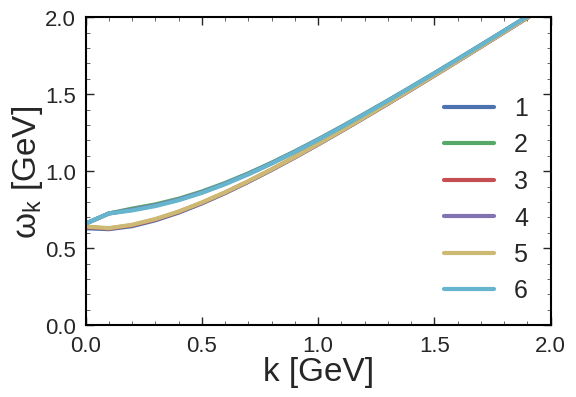

In [52]:
for i in [1, 2, 3, 4, 5, 6]:
    plt.plot(qrange, omK_iters[i][0][0, :], label='%i'%i)

plt.legend()
plt.ylim(0, 2.)
plt.xlim(0, 2)

plt.xlabel(r'k [GeV]')
plt.ylabel(r'$\omega_k$ [GeV]')

Text(0, 0.5, '$Im\\Sigma(\\omega_k, k)$ [GeV]')

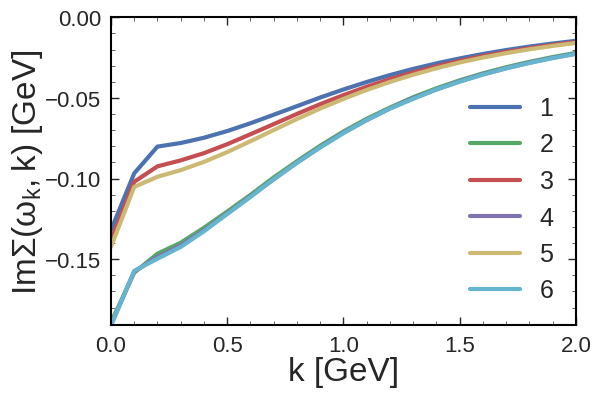

In [51]:
for i in [1, 2, 3, 4, 5, 6]:
    plt.plot(qrange, ImS_K_iters[i][0][:], label='%i'%i)

plt.legend()
# plt.ylim(0, 2.)
plt.xlim(0, 2)

plt.xlabel(r'k [GeV]')
plt.ylabel(r'$Im\Sigma(\omega_k, k)$ [GeV]')

Text(0, 0.5, '$\\Sigma_q$ [GeV]')

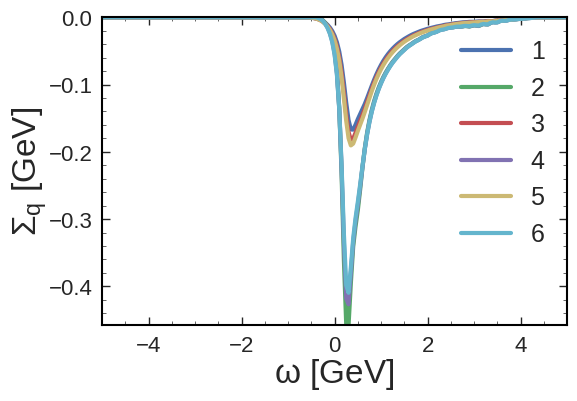

In [41]:
for i in [1, 2, 3, 4, 5, 6]:
    plt.plot(erange, imag(S_iters[i][0][:, 0]), label='%i'%i)

plt.legend()

plt.xlabel(r'$\omega$ [GeV]')
plt.ylabel(r'$\Sigma_q$ [GeV]')

In [37]:
G_iters

[[array([[-0.17855719-1.59426066e-03j, -0.17829374-1.58955914e-03j,
          -0.17752847-1.57594203e-03j, ..., -0.10165072-5.16656774e-04j,
          -0.10063552-5.06388187e-04j, -0.0996401 -4.96419755e-04j],
         [-0.18016556-1.62311313e-03j, -0.17989734-1.61828350e-03j,
          -0.17911827-1.60429645e-03j, ..., -0.10216999-5.21948939e-04j,
          -0.10114444-5.11522974e-04j, -0.10013898-5.01403297e-04j],
         [-0.18180316-1.65275597e-03j, -0.18153004-1.64779354e-03j,
          -0.1807368 -1.63342301e-03j, ..., -0.10269459-5.27322834e-04j,
          -0.10165854-5.16736258e-04j, -0.10064288-5.06462261e-04j],
         ...,
         [ 0.2325267 -2.70379884e-03j,  0.23297499-2.71423560e-03j,
           0.23429463-2.74507542e-03j, ...,  9.75109908-7.78277951e+00j,
          -9.53218629-1.30228173e+01j, -6.48209605-2.38538045e+00j],
         [ 0.22985469-2.64200793e-03j,  0.23029273-2.65208865e-03j,
           0.23158207-2.68187249e-03j, ...,  7.41625753-3.29186134e+00j,
     

Text(0, 0.5, '$Im G_q$ [GeV$^{-1}$]')

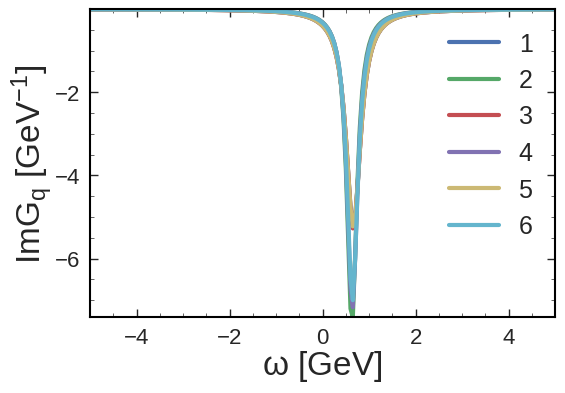

In [44]:
for i in [1, 2, 3, 4, 5, 6]:
    plt.plot(erange, imag(G_iters[i][0][:, 0]), label='%i'%i)

plt.legend()

plt.xlabel(r'$\omega$ [GeV]')
plt.ylabel(r'$Im G_q$ [GeV$^{-1}$]')

In [18]:
print(out_dir)

QP_output/first_run/0.20


In [60]:
np.savetxt(join(out_dir, 'Ss.dat'), Ss)
np.savetxt(join(out_dir, 'ImS_Ks.dat'), ImS_Ks)
np.savetxt(join(out_dir, 'om_Ks.dat'), omKs)


(-1.5, 0.0)

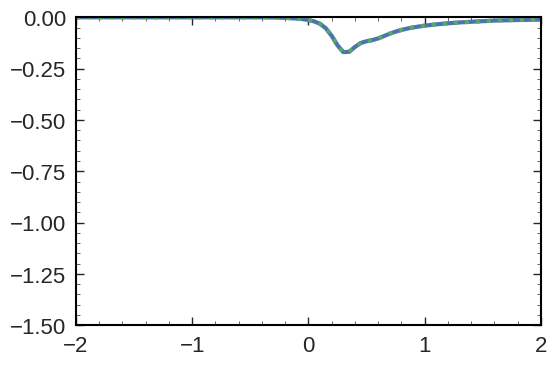

In [11]:
plt.plot(erange, imag(S_Q[:, 0]))
plt.plot(erange, imag(S_A[:, 0]), ls=':')

plt.xlim(-2, 2)
plt.ylim(-1.5, 0)

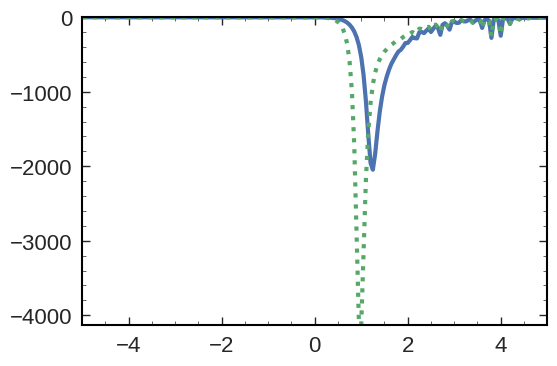

In [12]:
plt.plot(erange, imag(TMss[0][0][:, 0]))
plt.plot(erange, imag(TMss[0][1][:, 0]), ls=':')

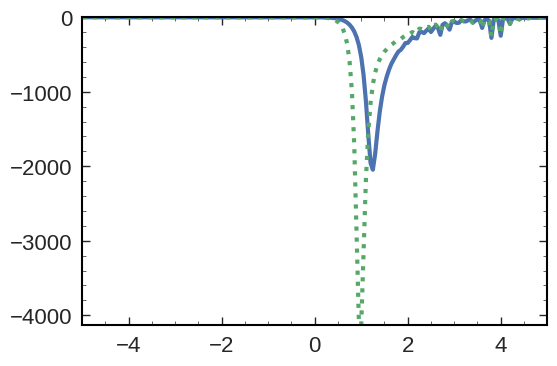

In [13]:
plt.plot(erange, imag(TMss[1][0][:, 0]))
plt.plot(erange, imag(TMss[1][1][:, 0]), ls=':')

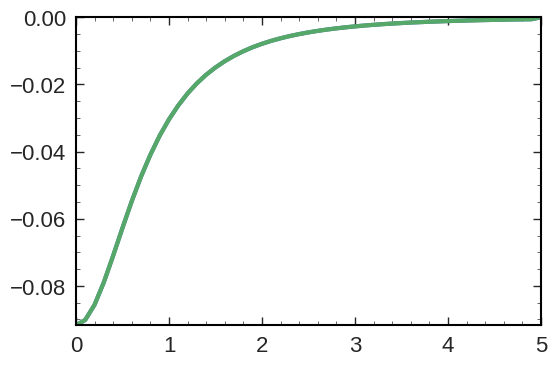

In [14]:
plt.plot(qrange, ImS_Ks[0])
plt.plot(qrange, ImS_Ks[1])

(0.0, 1.5)

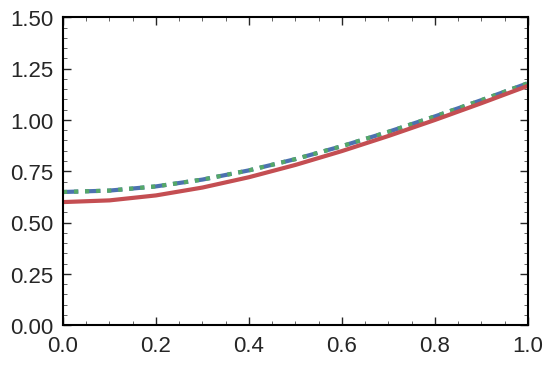

In [33]:
plt.plot(qrange, omKs[0], ls='--')
plt.plot(qrange, omKs[1], ls=':')
plt.plot(qrange, sqrt(mQ**2 + qrange**2))
plt.xlim(0, 1)
plt.ylim(0, 1.5)

In [16]:
S_Q = np.sum(Sigmass[0], axis=0)

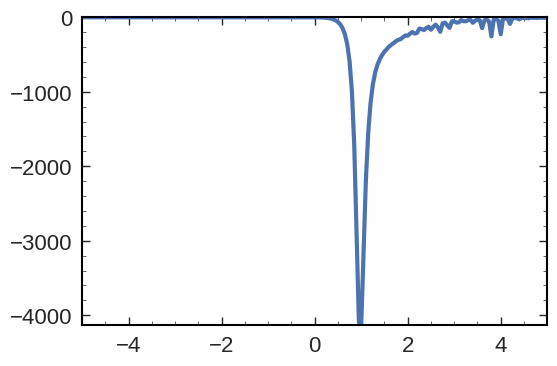

In [17]:
plt.plot(erange, imag(TM[:, 0]))

(0.0, 2.0)

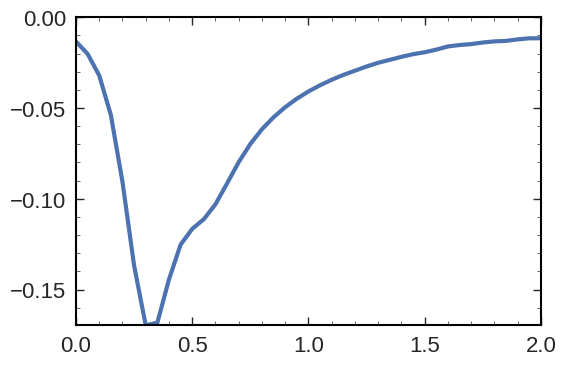

In [18]:
# plt.plot(erange, imag(Sigmass[0][0])[:, 0])
# plt.plot(erange, imag(Sigmass[0][1])[:, 0])
plt.plot(erange, imag(S_Q[:, 0]))

plt.xlim(0, 2)

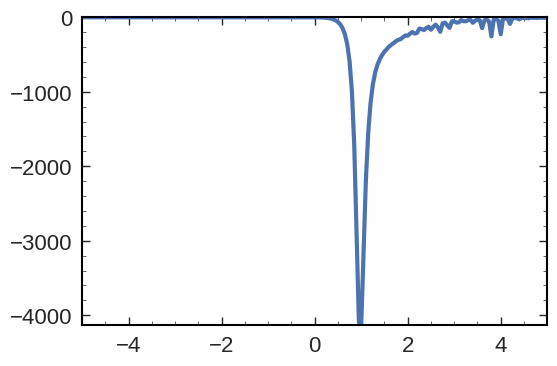

In [19]:
plt.plot(erange, [iImTM(0, e) for e in erange])

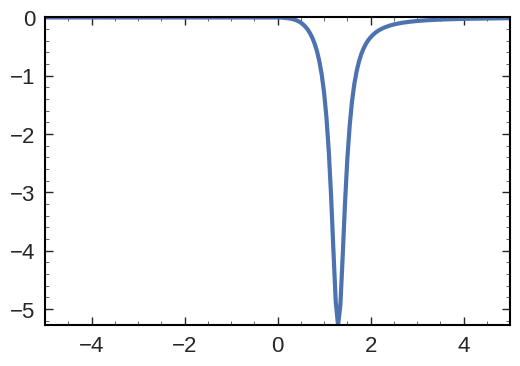

In [20]:
plt.plot(erange, [iImG2(0, e) for e in erange])

In [21]:
ch.get_T()

array([[-9.04778681e+02+5.31140326e-02j, -8.79127295e+02+4.86522124e-02j,
        -7.79054177e+02+3.78516342e-02j, ...,
        -4.90940849e-03+1.38377195e-07j, -4.34583994e-03+1.22473589e-07j,
        -3.85618811e-03+1.08658631e-07j],
       [-9.94228968e+02+6.73121267e-02j, -9.61758099e+02+6.15271638e-02j,
        -8.44653274e+02+4.76220818e-02j, ...,
        -5.17766532e-03+1.68756009e-07j, -4.58327537e-03+1.49359258e-07j,
        -4.06684864e-03+1.32510168e-07j],
       [-9.94971949e+02+7.05650247e-02j, -9.62442741e+02+6.44971335e-02j,
        -8.45193623e+02+4.99144699e-02j, ...,
        -5.17980753e-03+1.76740603e-07j, -4.58517143e-03+1.56426060e-07j,
        -4.06853087e-03+1.38779732e-07j],
       ...,
       [-7.29802504e+02-5.56658948e+00j, -7.15831265e+02-5.21739015e+00j,
        -6.46308706e+02-4.28277702e+00j, ...,
        -4.30054541e-03-2.05046507e-05j, -3.80691314e-03-1.81496318e-05j,
        -3.37801861e-03-1.61036719e-05j],
       [-7.31448049e+02-6.07464208e+00j, -7.

(0.0, 1.0)

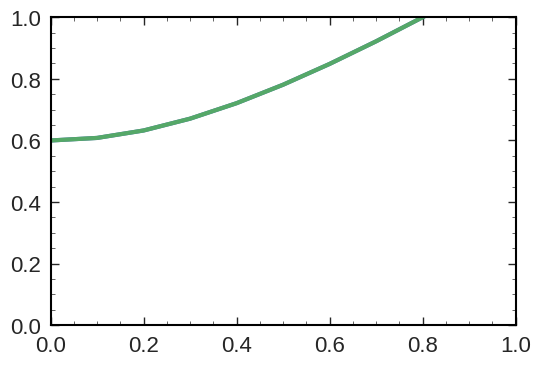

In [30]:
plt.plot(qrange, omArr[0, :])
plt.plot(qrange, sqrt(mQ**2 + qrange**2))

plt.xlim(0, 1)
plt.ylim(0, 1)

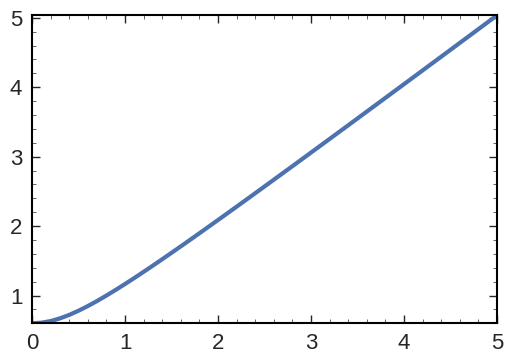

In [23]:
plt.plot(qrange, omArr[0, :])

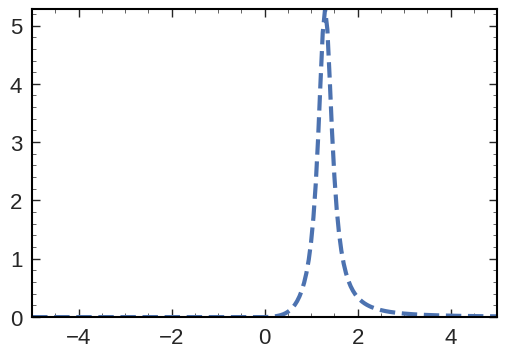

In [24]:
# plt.plot(erange, [-iImG2(0., e) for e in erange])
# plt.plot(erange, [-ch.iImG2(0., e) for e in erange], ls=':')
plt.plot(erange, -imag(G2[:, 0]), ls='--')
# plt.semilogy()

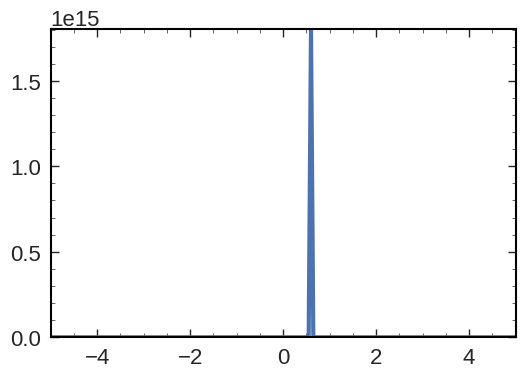

In [25]:
plt.plot(erange, 1/(erange - omArr[:, 0] ))

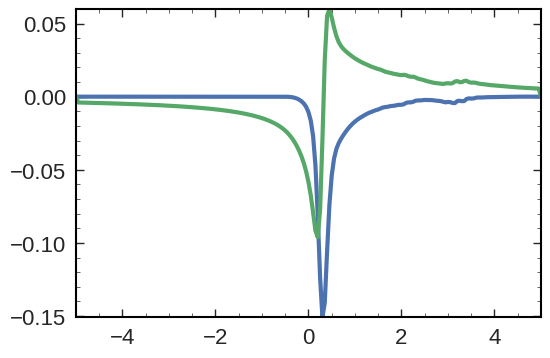

In [26]:
plt.plot(erange, ImS[:, 0])
plt.plot(erange, ReS[:, 0])

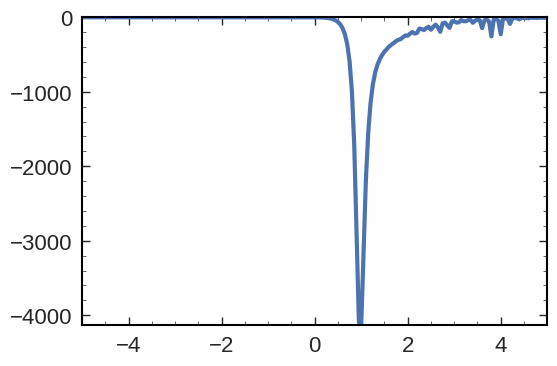

In [27]:
plt.plot(erange, imag(TM[:, 0]))

In [28]:
iImG2(0.5, 0.7), ch.iImG2(0.5, 0.7)

AttributeError: 'ChannelGroup' object has no attribute 'iImG2'

In [ ]:
X = array([
    tm.x_solve(e, 0, 0, T, ch.iVS[0], ch.iOm, iReG2, iImG2, 5, 1, 1)
    for e in erange])

In [60]:
TM = array([-4*pi*ch.v(q)**2 / (1 - X) for q in qrange]).transpose()

# Calculating $\Sigma$

In [132]:
iImTM = tm.InterDenom2D(qrange, erange, ascontiguousarray(nan_to_num(real(1/TM), posinf=0, neginf=0)), 
                        ascontiguousarray(nan_to_num(imag(1/TM), posinf=0, neginf=0)), 'imag')

iReTM = tm.InterDenom2D(qrange, erange, ascontiguousarray(nan_to_num(real(1/TM), posinf=0, neginf=0)), 
                        ascontiguousarray(nan_to_num(imag(1/TM), posinf=0, neginf=0)), 'real')